<a href="https://colab.research.google.com/github/moni-sarah/-GitHub-Actions/blob/main/diseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Accuracy: 1.0
Top-3 Accuracy: 1.0

Classification report:
                                          precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        24
                                   AIDS       1.00      1.00      1.00        24
                                   Acne       1.00      1.00      1.00        24
                    Alcoholic hepatitis       1.00      1.00      1.00        24
                                Allergy       1.00      1.00      1.00        24
                              Arthritis       1.00      1.00      1.00        24
                       Bronchial Asthma       1.00      1.00      1.00        24
                   Cervical spondylosis       1.00      1.00      1.00        24
                            Chicken pox       1.00      1.00      1.00        24
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.0

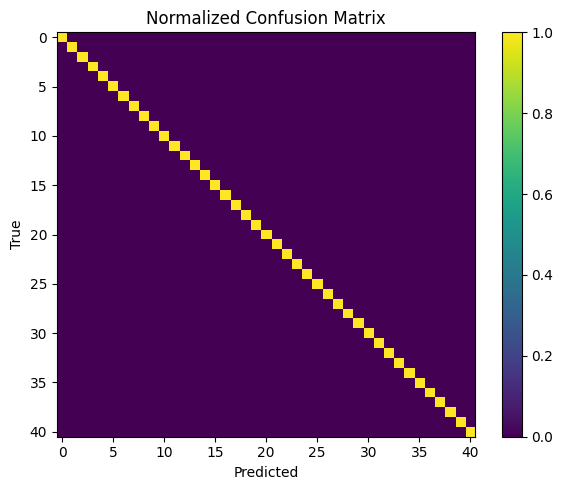

('/mnt/data/disease_model.pkl',
 '/mnt/data/symptom_cols.pkl',
 '/mnt/data/label_encoder.pkl',
 '/mnt/data/merged_dataset.csv')

In [7]:
# Rebuild a clean ML dataset with normalized symptom names, then train and evaluate a strong baseline.
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, top_k_accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import CalibratedClassifierCV
import joblib
import matplotlib.pyplot as plt
import os

# -----------------------------
# 1) Reload raw inputs
# -----------------------------
df_cases = pd.read_csv("/content/dataset.csv")
df_desc = pd.read_csv("/content/symptom_Description.csv")
df_prec = pd.read_csv("/content/symptom_precaution.csv")

# -----------------------------
# 2) Normalize symptom strings
# -----------------------------
symptom_cols = [c for c in df_cases.columns if c.lower().startswith("symptom_")]

def clean_symptom(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    # fix stray spaces around underscores and multiple spaces
    s = re.sub(r"\s*_\s*", "_", s)
    s = re.sub(r"\s+", " ", s)
    s = s.replace(" ", "_")
    return s

for c in symptom_cols:
    df_cases[c] = df_cases[c].apply(clean_symptom)

# -----------------------------
# 3) Build Symptoms list per row
# -----------------------------
df_cases["Symptoms"] = df_cases[symptom_cols].apply(
    lambda row: [sym for sym in row if pd.notnull(sym)], axis=1
)

# -----------------------------
# 4) Merge with descriptions & precautions
# -----------------------------
merged = df_cases[["Disease", "Symptoms"]].merge(df_desc, on="Disease", how="left")
merged = merged.merge(df_prec, on="Disease", how="left")

# -----------------------------
# 5) One-hot encode symptoms
# -----------------------------
all_symptoms = sorted({sym for row in merged["Symptoms"] for sym in row})
X_sym = pd.DataFrame(
    [[1 if s in row else 0 for s in all_symptoms] for row in merged["Symptoms"]],
    columns=all_symptoms
)
ml_df = pd.concat([merged.drop(columns=["Symptoms"]), X_sym], axis=1)

# -----------------------------
# 6) Train/Val split and label encoding
# -----------------------------
feature_cols = all_symptoms
X = ml_df[feature_cols].copy()
y_text = ml_df["Disease"].copy()

le = LabelEncoder()
y = le.fit_transform(y_text)

X_train, X_test, y_train, y_test, y_text_train, y_text_test = train_test_split(
    X, y, y_text, test_size=0.2, random_state=42, stratify=y
)

# -----------------------------
# 7) Strong baseline model
#    - RandomForest with class_weight balanced
#    - Probability calibration (isotonic) for better confidence outputs
# -----------------------------
base_rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

cal_rf = CalibratedClassifierCV(base_rf, method="isotonic", cv=3)
cal_rf.fit(X_train, y_train)

# -----------------------------
# 8) Evaluation
# -----------------------------
y_pred = cal_rf.predict(X_test)
y_proba = cal_rf.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
top3 = top_k_accuracy_score(y_test, y_proba, k=3)
report = classification_report(y_test, y_pred, target_names=le.classes_)

print("Accuracy:", round(acc, 4))
print("Top-3 Accuracy:", round(top3, 4))
print("\nClassification report:\n", report)

# Confusion matrix (normalized)
cm = confusion_matrix(y_test, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(cm, aspect='auto')
ax.set_title("Normalized Confusion Matrix")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

# -----------------------------
# 9) Persist artifacts for API
# -----------------------------
model_path = "/mnt/data/disease_model.pkl"
cols_path = "/mnt/data/symptom_cols.pkl"
le_path = "/mnt/data/label_encoder.pkl"
clean_path = "/mnt/data/merged_dataset.csv"

# Create the directory if it doesn't exist
os.makedirs("/mnt/data", exist_ok=True)

joblib.dump(cal_rf, model_path)
joblib.dump(feature_cols, cols_path)
joblib.dump(le, le_path)
ml_df.to_csv(clean_path, index=False)

# Show saved file paths
(model_path, cols_path, le_path, clean_path)

In [ ]:
# app.py
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
from pydantic import BaseModel, Field
import joblib, pandas as pd, numpy as np
from typing import List, Dict
import os

# --- Load artifacts ---
MODEL = joblib.load("/mnt/data/disease_model.pkl")
SYMPTOMS: List[str] = joblib.load("/mnt/data/symptom_cols.pkl")
LE = joblib.load("/mnt/data/label_encoder.pkl")
META = pd.read_csv("/mnt/data/merged_dataset.csv")

# --- API setup ---
app = FastAPI(title="Disease Prediction API", version="1.0")
app.add_middleware(
    CORSMiddleware,
    allow_origins=["*"], allow_credentials=True,
    allow_methods=["*"], allow_headers=["*"]
)

class PredictIn(BaseModel):
    symptoms: List[str] = Field(default_factory=list, description="symptom names (lowercase with underscores)")
    top_k: int = Field(default=3, ge=1, le=5)

def lookup_meta(disease_name: str) -> Dict:
    row = META[META["Disease"] == disease_name].head(1)
    if row.empty:
        return {}
    r = row.iloc[0]
    return {
        "description": r.get("Description", None),
        "precautions": [r.get("Precaution_1"), r.get("Precaution_2"),
                        r.get("Precaution_3"), r.get("Precaution_4")]
    }

@app.post("/predict")
def predict(payload: PredictIn):
    # one-hot encode input
    x = np.array([1 if s in payload.symptoms else 0 for s in SYMPTOMS], dtype=np.int32).reshape(1, -1)

    # calibrated probabilities
    proba = MODEL.predict_proba(x)[0]
    idx_sorted = np.argsort(proba)[::-1][:payload.top_k]
    results = []
    for i in idx_sorted:
        disease = LE.inverse_transform([i])[0]
        meta = lookup_meta(disease)
        results.append({
            "disease": disease,
            "confidence": float(round(proba[i], 4)),
            "description": meta.get("description"),
            "precautions": [p for p in meta.get("precautions", []) if isinstance(p, str)]
        })

    return {
        "input_symptoms": payload.symptoms,
        "predictions": results
    }

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/disease_model.pkl'

In [ ]:
!uvicorn ipynb_server:app --reload --port 8000 &

INFO:     Will watch for changes in these directories: ['/content']
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)
INFO:     Started reloader process [3023] using StatReload
ERROR:    Error loading ASGI app. Could not import module "ipynb_server".
INFO:     Stopping reloader process [3023]


The API is now running in the background on port 8000. You can now interact with it using tools like `curl` or by making requests from another application.

For example, you can use `curl` to test the `/predict` endpoint:

First, mount your Google Drive to access it from this notebook.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, copy the saved model artifacts from `/mnt/data/` to your Google Drive. You can specify the destination path in your Drive.

In [8]:
import os
import shutil

source_dir = "/mnt/data"
destination_dir = "/content/drive/MyDrive/DiseasePredictionArtifacts" # You can change this path

# Create the destination directory in Drive if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# List of files to copy
files_to_copy = ["disease_model.pkl", "symptom_cols.pkl", "label_encoder.pkl", "merged_dataset.csv"]

# Copy each file
for file_name in files_to_copy:
    source_path = os.path.join(source_dir, file_name)
    destination_path = os.path.join(destination_dir, file_name)
    if os.path.exists(source_path):
        shutil.copy2(source_path, destination_path)
        print(f"Copied {file_name} to {destination_dir}")
    else:
        print(f"Warning: {file_name} not found in {source_dir}")

print("\nArtifacts copied to Google Drive.")

Copied disease_model.pkl to /content/drive/MyDrive/DiseasePredictionArtifacts
Copied symptom_cols.pkl to /content/drive/MyDrive/DiseasePredictionArtifacts
Copied label_encoder.pkl to /content/drive/MyDrive/DiseasePredictionArtifacts
Copied merged_dataset.csv to /content/drive/MyDrive/DiseasePredictionArtifacts

Artifacts copied to Google Drive.
